In [3]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

<a id="eda_fe"></a>
## Figure default parameters

Throughout the notebook I will create manuy figures. In order to save time and avoid having to set the parameters for each plot, I will define the default font and font sizes for all the plots.


In [4]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

# Load data

I initially used [the National Grid](https://data.nationalgrideso.com) API to acess the historic electricity demand between 2009 and 2022. I uploaded the [dataset](https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022) to Kaggle and I will be using it in this notebook.

In [7]:
df = pd.read_csv("/content/historic_demand_2009_2024.csv", index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

<a id='eda'></a>
# EDA and Feature engineering

In this section, I will go through several steps to understand and transform the original dataset. The steps I will follow are:
* Data understanding. Have a first look at the timeseries dataset
* Data preparation. Deal with null values, drop uninformative features and remove outliers
* Feature understanding. Understand the trend and different seasonalities in the data

## Data understanding

The [dataset](https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022) includes a description of all the columns, but for this project I will only use three columns:

* SETTLEMET_DATA: date in format dd/mm/yyyy
* SETTLEMENT_PERIOD: half hourly period for the historic outtunr occurred
* TSD (Transmission System Demand). Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW.

TSD is target variable and the aim is to predict the future demand using different models.


Let's have a quick look at the data and the their statistics:

In [8]:
df.sample(n=7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,greenlink_flow,is_holiday
117788,2015-09-20,31,28859,29452,26038,848,3984,2570,8887,0,...,1017,93,-86,0,NaN,NaN,NaN,NaN,NaN,0
58425,2012-05-02,8,27509,29589,24851,107,2019,0,1476,0,...,994,-382,0,0,NaN,NaN,NaN,NaN,NaN,0
239629,2022-09-02,15,24628,29515,22338,775,6545,345,13861,0,...,341,87,382,-534,-766.0,-1017.0,NaN,NaN,NaN,0
168044,2018-08-02,47,26518,27031,24190,649,5913,0,13052,0,...,939,74,324,0,NaN,NaN,NaN,NaN,NaN,0
97335,2014-07-21,17,34492,35222,31538,231,3344,1130,5023,0,...,996,0,-222,0,NaN,NaN,NaN,NaN,NaN,0
277468,2024-10-29,29,31649,35237,29159,1019,6622,1505,17194,0,...,-666,-452,-530,175,1397.0,-2.0,1400.0,-1327.0,0.0,0
220060,2021-07-21,26,27847,29350,24957,337,6527,8130,13080,0,...,1041,-454,-536,999,-1.0,0.0,NaN,NaN,NaN,0


In [9]:
df.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,...,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,greenlink_flow,is_holiday
count,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,...,279264.000000,279264.000000,279264.000000,279264.000000,103968.000000,103968.000000,33840.000000,33840.000000,16320.0,279264.000000
mean,24.500229,31186.565042,32627.843779,28389.002868,1270.098774,4447.695772,878.177069,8685.163430,6.654220,304.734674,...,503.999842,-125.610222,-50.967919,175.876626,416.582977,114.173929,1704.910757,196.312145,0.0,0.022516
std,13.853821,7827.270027,7710.008440,7087.628201,966.304596,1957.216235,1709.142408,5875.188186,39.150778,528.372063,...,541.490053,230.333166,262.941668,421.668169,650.866003,490.431568,1825.530303,562.922278,0.0,0.148356
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,...,-1215.000000,-505.000000,-585.000000,-1023.000000,-1455.000000,-1028.000000,-2851.000000,-1465.000000,0.0,0.000000
25%,12.750000,24908.000000,26582.000000,22677.000000,551.000000,2102.000000,0.000000,2028.000000,0.000000,8.000000,...,0.000000,-304.000000,-208.000000,0.000000,0.000000,0.000000,267.750000,0.000000,0.0,0.000000
50%,24.500000,30495.000000,31782.000000,27756.000000,1016.000000,4831.000000,0.000000,11503.000000,0.000000,11.000000,...,725.000000,-149.000000,0.000000,0.000000,0.000000,0.000000,1543.000000,0.000000,0.0,0.000000
75%,36.250000,36913.000000,38096.000000,33615.000000,1726.000000,6527.000000,883.000000,13080.000000,0.000000,368.000000,...,994.000000,24.000000,0.000000,332.000000,1095.000000,75.000000,3058.000000,512.000000,0.0,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5930.000000,6622.000000,11224.000000,17197.000000,893.000000,2019.000000,...,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,6585.000000,1436.000000,0.0,1.000000


In [10]:
df.shape

(279264, 23)

Let's sort the values by date as some of them have been misplaced in the original dataset

In [11]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

## Data preparation

The goal of this section is to prepare the data for the model. To do so, I will perform the following actions:
* Find out how many `nan` values there are and drop the columns containing `nan` values
* Drop rows whose `settlement_period` exceeds 48, as the API states that 48 is the maximum number of samples per day
* Remove outliers

As a bonus, I will add a new feature at this point, bank holidays in the UK. The reason to add them at this point is that I will trasnform the date format for better analysis in a future section. Therefore, it's easier for me to add the bank holidays while performing data preparation.

Let's begin checking if there are`nan` values:

In [12]:
df.isna().any()

,0
settlement_date,False
settlement_period,False
nd,False
tsd,False
england_wales_demand,False
embedded_wind_generation,False
embedded_wind_capacity,False
embedded_solar_generation,False
embedded_solar_capacity,False
non_bm_stor,False


As can be seen, only two columns include `nan` values. Let's check how many `nan` values there are in each column:

In [13]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

,nsl_flow,eleclink_flow
True,175296,175296
False,103968,103968


It seems that both features have the same number of `nan` values. Let's have a look at that the dataframe containing the `nan` value:

In [14]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,greenlink_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,...,0,-161,0,0,NaN,NaN,NaN,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,...,0,-160,0,0,NaN,NaN,NaN,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,...,0,-160,0,0,NaN,NaN,NaN,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,...,0,-160,0,0,NaN,NaN,NaN,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,...,0,-160,0,0,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,2018-12-31,44,26826,28428,25195,2734,5918,0,13052,0,...,777,-454,-535,0,NaN,NaN,NaN,NaN,NaN,0
175292,2018-12-31,45,25660,27542,24145,2730,5918,0,13052,0,...,-268,-455,-536,0,NaN,NaN,NaN,NaN,NaN,0
175293,2018-12-31,46,25047,26971,23496,2726,5918,0,13052,0,...,-297,-455,-536,0,NaN,NaN,NaN,NaN,NaN,0
175294,2018-12-31,47,24188,26224,22683,2673,5918,0,13052,0,...,-467,-454,-466,0,NaN,NaN,NaN,NaN,NaN,0


It seems that neither feature existed from 2009 to 2018. The best thing is to drop these features.

Also, I will remove the rows where the `settlement_period` exceeds 48, as the maximum number is 48. Any values larger than 48 is a fault when logging the data.

In [15]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

### Bank holidays

Bank holidays are very important in time series forecasting as they often affect the data values on those days. Therefore, I want to add a new column to my dataset to state whether each day was bank holiday or not. I began by checking the [UK governement bank holiday API](https://github.com/alphagov/calendars), but it only goes back to 2015.

My next option was to check StackOverflow and [oen of the questions](https://stackoverflow.com/questions/37677112/adding-holidays-columns-in-a-dataframe-in-python) was related to this issue. The asnwers suggest using [Python Workalendar](https://workalendar.github.io/workalendar/), but for some reason it was adding more bank holidays than it should (I verified this using other websites).

Luckily, an entry in [Stack Exchange](https://opendata.stackexchange.com/a/13215) covered this topic too and one of the answers suggested using [Python holidays](https://github.com/dr-prodigy/python-holidays), which after checking the [Python Holidays API](https://python-holidays.readthedocs.io/en/latest/api.html) I managed to make work for my usecase.

Since the dataset covers electricity demand for England and Wales, the first step is to check that the two countries have the same bank holidays:

In [16]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


Having seen that the bank holidays are the same, I can proceed with this python package to extract the bank holidays and store them in the right format.

It's worth noting that this package includes the original bank holiday and when it was observed. I will only store the observed days.

In [17]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[np.datetime64('2009-01-01'),
 np.datetime64('2009-04-10'),
 np.datetime64('2009-04-13'),
 np.datetime64('2009-05-04'),
 np.datetime64('2009-05-25')]

Once I've verified that the holidays are correctly loaded, one can compare the `holiday_dates` variable and the date in the dataset and store the boolean output in a new column:

In [19]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,scottish_transfer,viking_flow,greenlink_flow,is_holiday
140302,2017-01-02,15,27126,28358,24887,1383,4871,0,11503,0,...,-551,0,424,-48,158,0,NaN,NaN,NaN,1
122431,2015-12-26,46,25319,26130,22672,2672,4013,0,9063,0,...,1996,0,934,-4,-190,0,NaN,NaN,NaN,1
192515,2019-12-26,10,19740,22439,17987,2326,6465,0,13080,0,...,1405,0,-557,81,504,414,NaN,NaN,NaN,1
94605,2014-05-26,10,20465,22986,18336,225,2718,0,4755,0,...,1754,0,878,-199,-338,0,NaN,NaN,NaN,1
116817,2015-08-31,48,23726,24242,21505,609,3977,0,8841,0,...,1603,0,816,37,49,0,NaN,NaN,NaN,1
129888,2016-05-30,17,24351,25454,21317,972,4260,1400,10500,0,...,1195,0,709,-154,-439,0,NaN,NaN,NaN,1
35054,2011-01-01,19,29575,30613,26794,509,1730,1,79,0,...,1990,0,0,-432,0,0,NaN,NaN,NaN,1


The sample dataframe above is ok to make sure that the new column has been created, but one can inspect the bank holidays more easily using a plot.

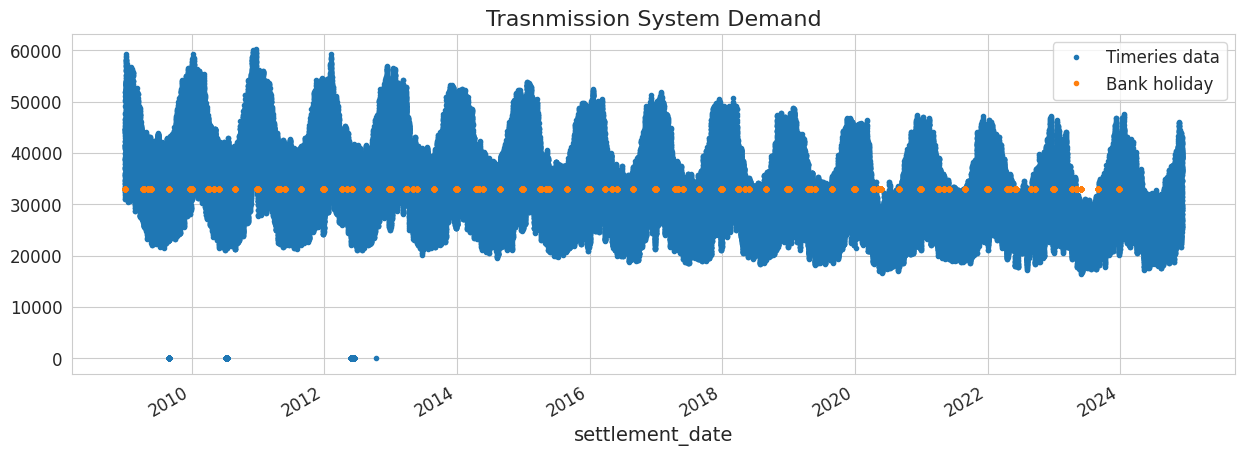

In [20]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

That plot is great to see the behaviour of the time series data. I can see a decreasing trend and a clear yearly seasonality. However, this plot also shows the presence of data points equal to 0. These values will be removed in the next section.

Before dealing with outliers, in the above graph we can see a yearly trend, but we cannot focus on daily or weekly patterns. Therefore, let's create a new plot focusing on a single week:

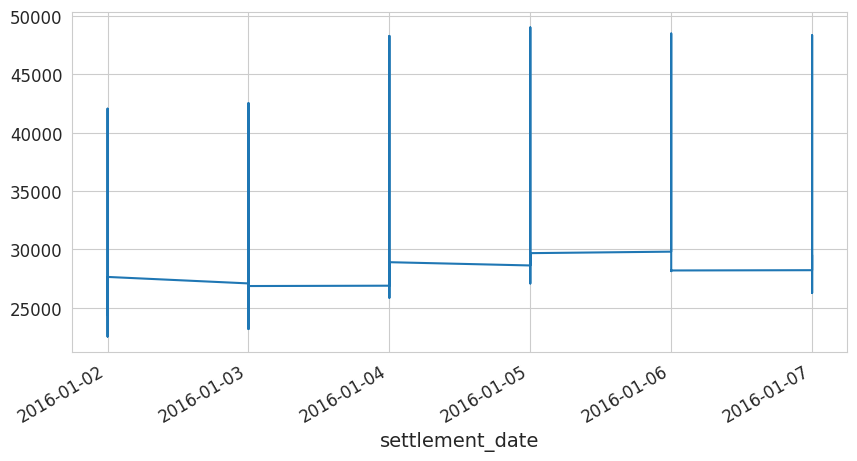

In [21]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

This plot isn't what I was expecting... Am I plotting the right parameter or is there something wrong in the dataset? One can begin by inspecting the dataframe:

In [22]:
df_plot.head()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,scottish_transfer,viking_flow,greenlink_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,,,,
2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,NaN,1
2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,NaN,1
2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,NaN,1
2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,NaN,1
2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,NaN,1


The plot wasn't wrong! In the process of seeting the date as the index I haven't added the hour. Therefore, the 48 samples per day are overlayed on top of each other.

Before going forward I need to do two things:
* Remove outliers
* Add the hour to the date and set it as the index

### Outlier analysis

In the plot above, one can see that there are multiple 0 values. A histogram will show how many samples are actually equal to 0.

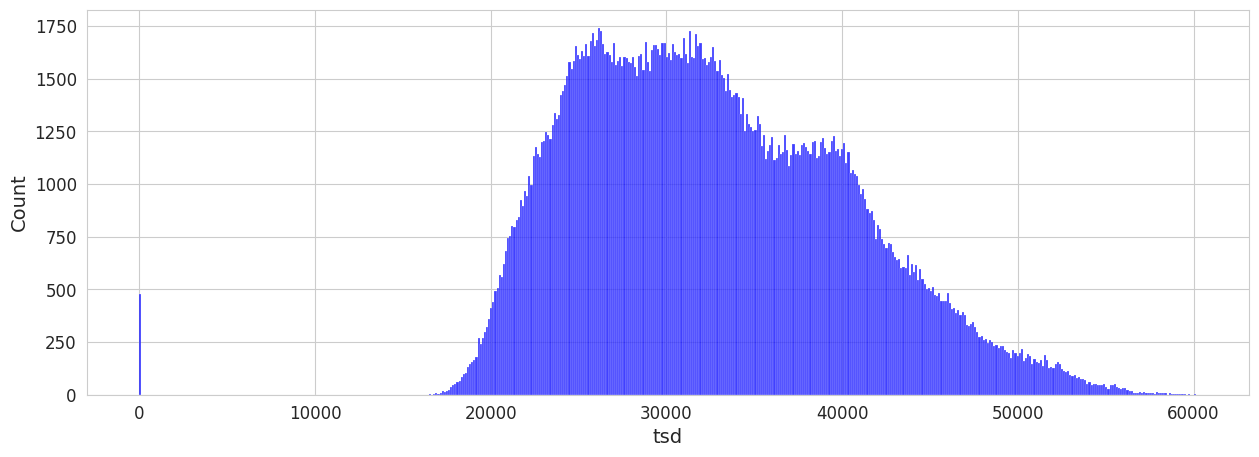

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

I will not only delete the values equal to 0 but the entire day where there are values equal to 0. The reason being that otherwise the remaining daily values would not be representative of the entire day, which becomes more relevant for the SARIMA models as I will be using daily data instead of hourly.

In [24]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

## Feature creation

The first step in the feature creation is to change the date format to include the hourly values. The `settlement_period` values refer to how many samples have been taken per day. Given that there are 48 samples per day, each sample represents 30 minutes of the day. Using this information together with the valuable knowledge of the [StackOverflow](https://stackoverflow.com/questions/61444409/convert-a-pandas-column-to-hours-and-minutes) [contributors](https://stackoverflow.com/questions/51846547/how-to-convert-float-into-hours-minutes-seconds), I managed to change the date format.

In [25]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,scottish_transfer,viking_flow,greenlink_flow,is_holiday
9593,2009-07-19,44,21:30:00,31265,31823,28574,961,1725,0,0,...,2001,0,0,-49,0,0,NaN,NaN,NaN,0
262220,2024-01-01,27,13:00:00,29377,30790,26831,1408,6488,1523,16726,...,2001,-4,1003,-271,-531,999,541.0,780.0,0.0,0
142191,2017-02-25,32,15:30:00,33782,34509,31119,2754,4831,364,11750,...,996,0,972,-121,54,0,NaN,NaN,NaN,0
136401,2016-10-28,2,0:30:00,22579,26118,20753,1948,4932,0,11433,...,-1641,0,911,297,0,0,NaN,NaN,NaN,0
208796,2020-12-14,21,10:00:00,35380,35991,32664,2689,6527,1970,13080,...,16,-2,0,195,412,1000,NaN,NaN,NaN,0
156547,2017-12-21,38,18:30:00,43592,45121,39245,689,5754,0,12916,...,779,0,969,-455,-463,0,NaN,NaN,NaN,0
196003,2020-03-22,42,20:30:00,32154,32765,29503,2414,6504,0,13080,...,2003,0,1000,128,47,1000,NaN,NaN,NaN,0


As can be seen, a new column called `period_hour` includes the hour at which the electricity demand measurement was taken. One can now combine it with the actual date as follows:

In [26]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,scottish_transfer,viking_flow,greenlink_flow,is_holiday
224259,2021-11-01 14:30:00,30,14:30:00,32659,34122,30382,3121,6527,1920,13080,...,1006,991,991,-454,-401,998,NaN,NaN,NaN,0
15717,2009-11-26 11:30:00,24,11:30:00,43825,46414,39692,1498,1740,0,0,...,-1534,0,0,-450,0,0,NaN,NaN,NaN,0
100232,2014-10-05 10:00:00,21,10:00:00,30568,31703,27839,705,3679,1890,5413,...,1996,0,991,-222,-403,0,NaN,NaN,NaN,0
56800,2012-04-04 12:00:00,25,12:00:00,43792,44493,39508,1141,2019,269,1440,...,998,0,982,-412,0,0,NaN,NaN,NaN,0
142552,2017-03-05 04:00:00,9,4:00:00,23203,25371,20845,1325,4831,0,11750,...,1877,0,928,192,287,0,NaN,NaN,NaN,0


The `settlement_date` column is now in the right format to use an index:

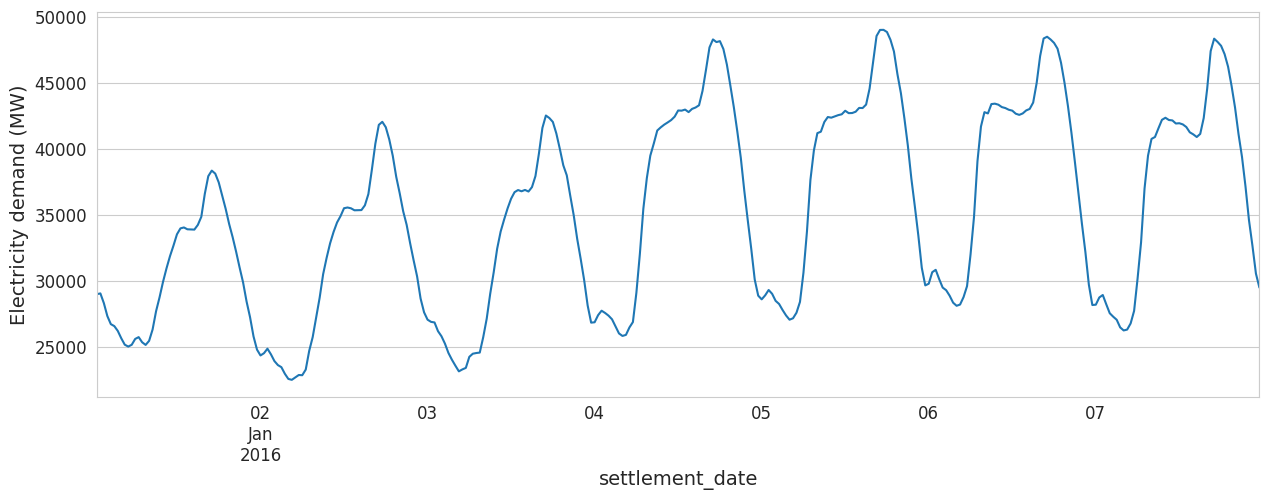

In [27]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

While adding extra features will not improve the prediction for the SARIMA models, XGBoost will benefit from it. The new features constits of different bits of information "already stored" in the date, such as the day of the week and the day of the year. Given the seasonality of the time series data, these features might lead to more accurate predictions. The second part is adding lags. Again, XGBoost will benefit from this.

In [28]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [29]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2015-06-29 13:30:00,28,13:30:00,32059,33271,28965,871,3889,5920,8703,0,...,29,0,180,2,6,2015,27,36797.0,37142.0,39886.0
2013-07-05 08:00:00,17,8:00:00,35680,36564,32624,299,2102,851,2831,125,...,5,4,186,3,7,2013,27,37532.0,37376.0,NaN
2019-01-09 09:00:00,19,9:00:00,42615,44203,38490,1071,5918,709,13052,14,...,9,2,9,1,1,2019,2,44493.0,40788.0,45036.0
2014-09-12 22:00:00,45,22:00:00,31193,31953,28238,312,3870,0,5285,0,...,12,4,255,3,9,2014,37,33176.0,32263.0,32623.0
2011-03-18 22:00:00,45,22:00:00,37776,38835,34083,302,1737,0,123,0,...,18,4,77,1,3,2011,11,36816.0,37399.0,NaN


## Feature understanding

In this section, I will explore the distribution of electricity demand with respect the different features, such as as hour, month or year. This is a great way to understand the seasonalities in the time series.

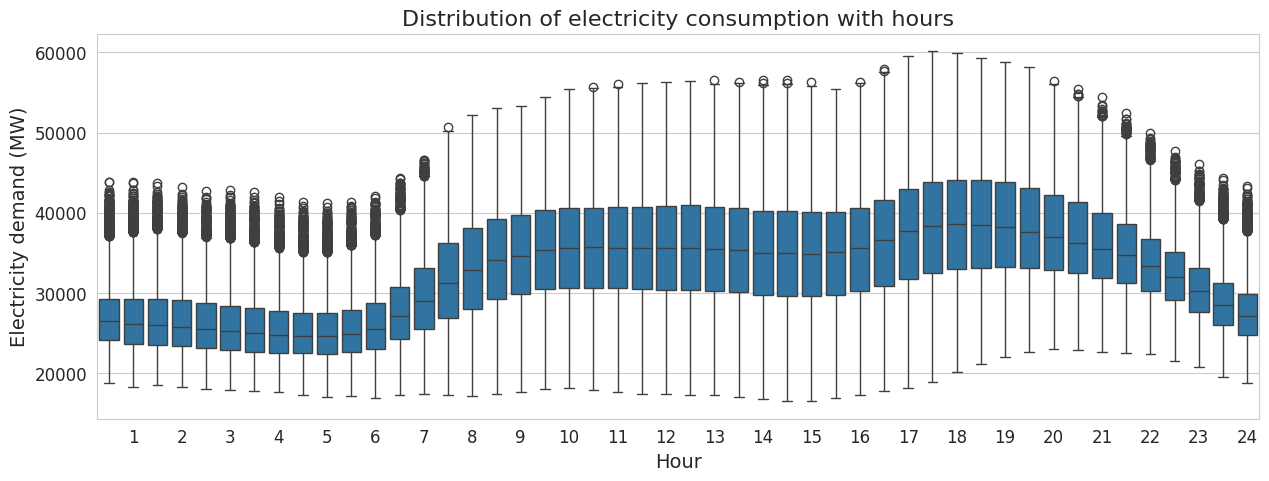

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

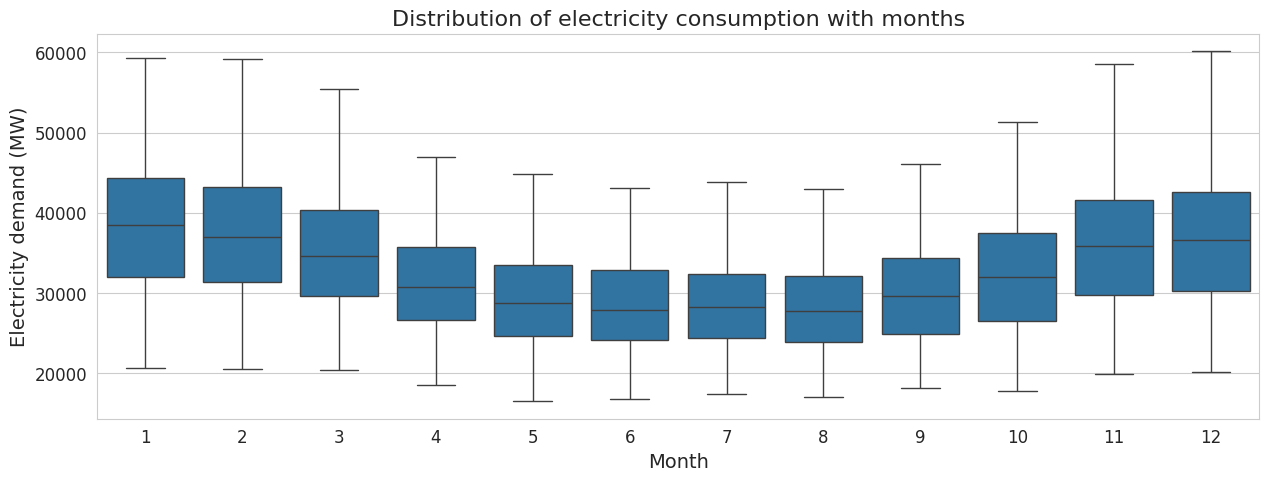

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

It seems that the lowest consumption occurs during the summer months. Having grown up in Spain, this is a rare concept for me as everyone switches their AC on, resulting in higher consumption.

Let's plot on the years, for example 2016, to make sure that I selected the right variable in the above plot.

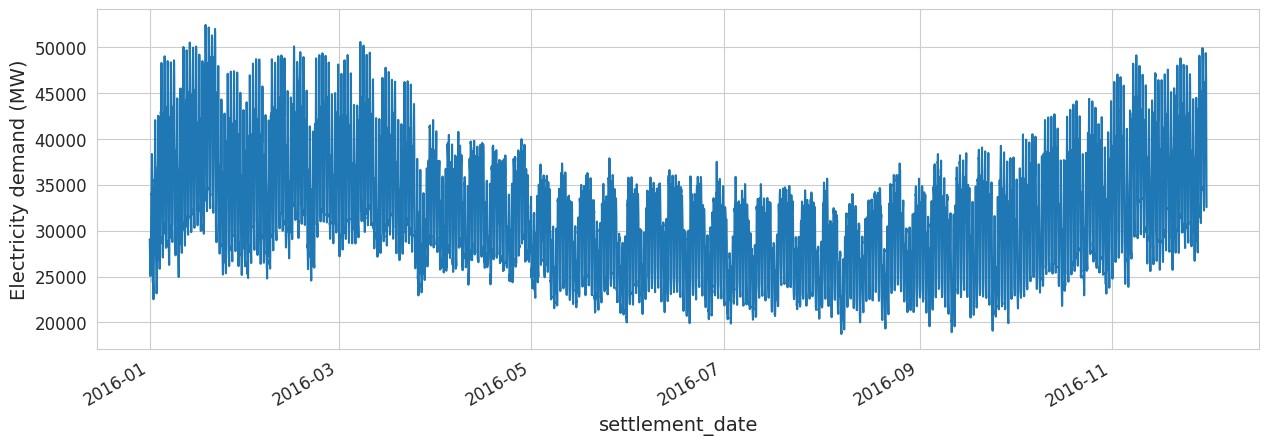

In [32]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

This plot supports the finding from the previous graph.

Let's look at the effect of bank holidays on electricity consumption:

<ipython-input-33-a43933627e79>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


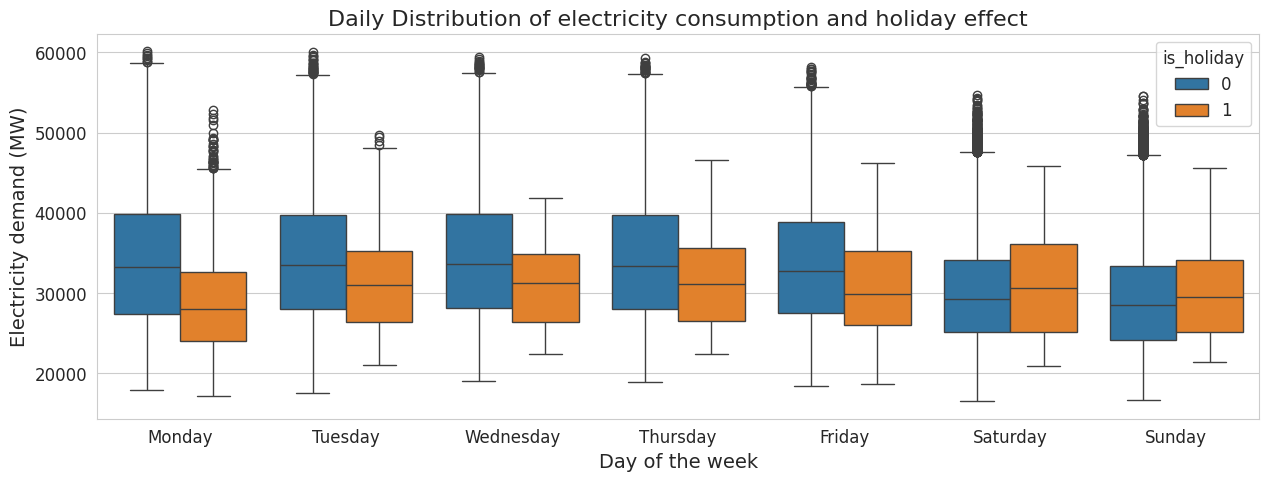

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

It seems that from Mondat to Friday, the electricity consumption is on average lower on bank holidays, whereas it is higher on Saturday and it's the same on Sundays.

For non bank holiday, the demand on the weekend is lower than during week days.

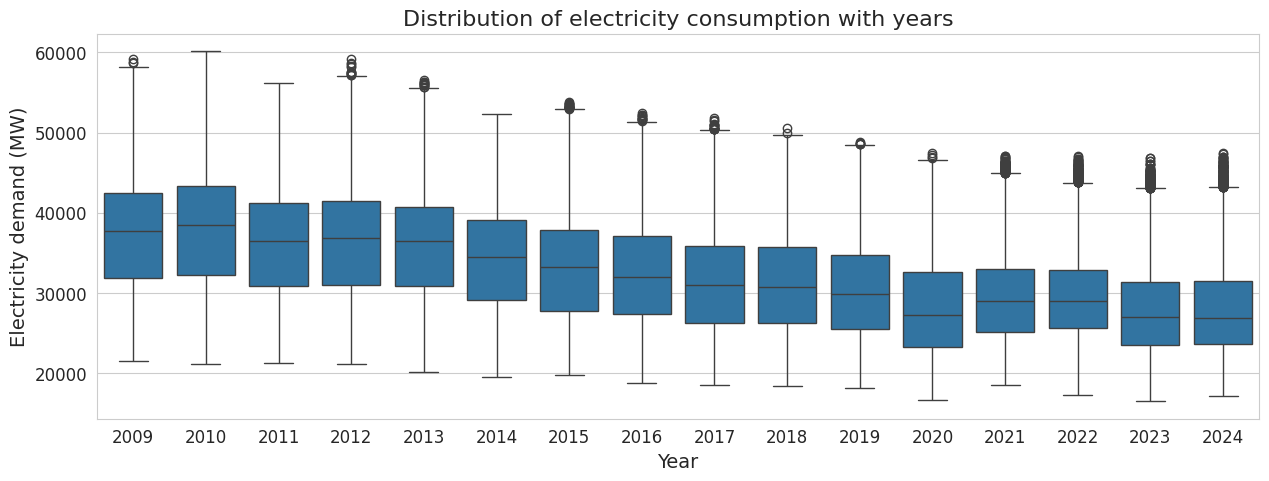

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

Although these are yearly average values, one can see a decreasing trend in the electricity consumption. We can overlay the electricity consumption of two years to see how they compare:

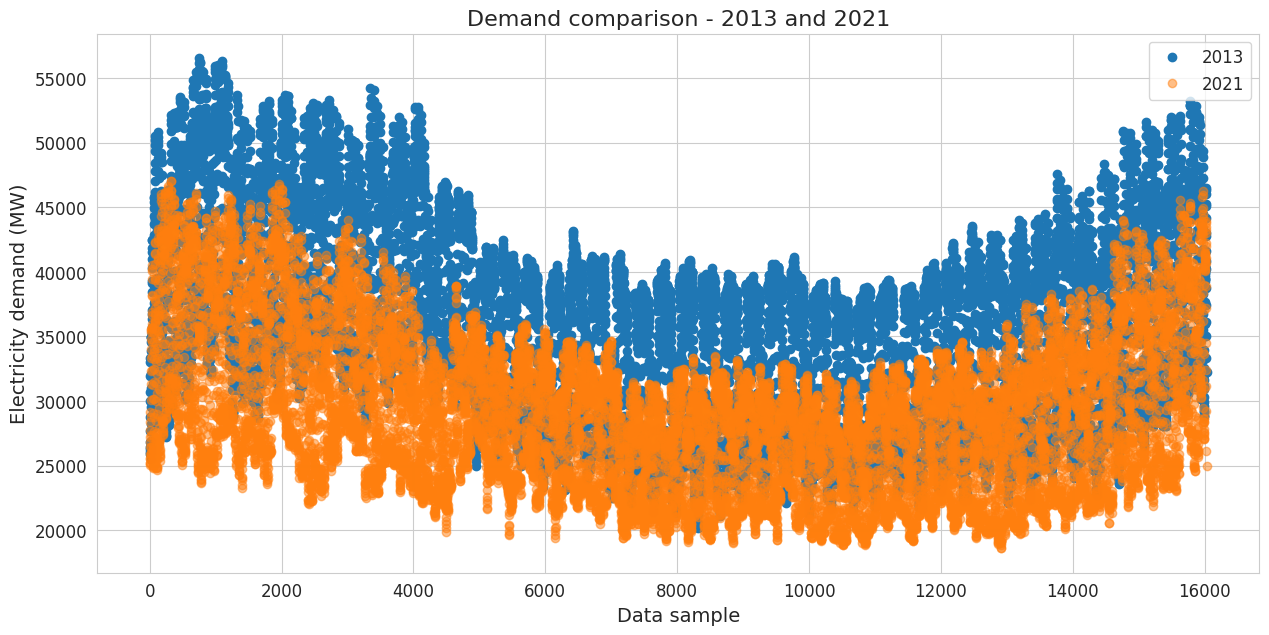

In [35]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

Again, this plot confirms that electricity consumption is decreasing in recent years.

# Time-series models

Once I've gained enough understanding of the time series data, I'm ready to create different models and check their accuracy on the predictions. In order to compare the results of the models, I will use the Mean Absolute Percentage Error, which I implemented as follows:

In [36]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

<a id='xgboost'></a>

# XGboost

The second forecasting method I will use is XGBoost. It isn't a forecasting tool per se, but a regression tool. While traditional regression techniques struggle with time series forecasting, XGBoost does a great job as we will see. Also, XGBoost can use multiple features instead of just the electricity demand.

I was inspired to use XGBoost for time series forecasting after seeing a couple of Youtube videos ([video 1](https://www.youtube.com/watch?v=vV12dGe_Fho&t=3s) and [video 2](https://www.youtube.com/watch?v=z3ZnOW-S550&t=800s)) from [Rob Mulla](https://www.kaggle.com/robikscube).

### Simple XGBoost model
The first XGBoost model is a simple model for which some of the parameters are defined and the data is split into train and test sets. This model is fairly simple, but it's a great baseline

#### Training - test split
The first step is to split the data. I will split the data into train, test and hold-out set. The hold-out set will be used for independent evaluation of the model while the model is being trained.

In [56]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

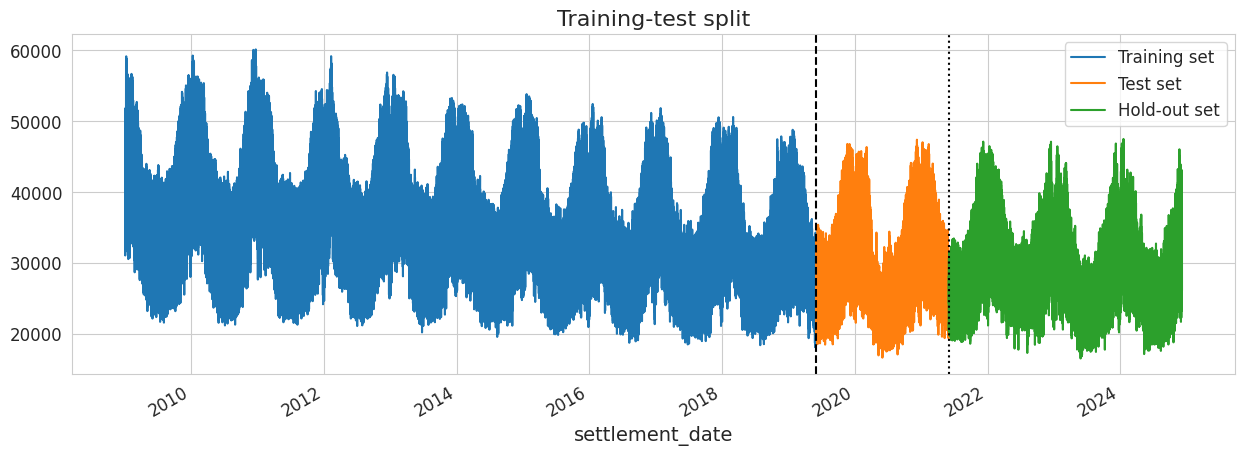

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

In [58]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
#     tree_method="gpu_hist",
    random_state=43,
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
);


[0]	validation_0-rmse:7537.22500	validation_1-rmse:8346.85689
[100]	validation_0-rmse:4933.76548	validation_1-rmse:6453.99074
[200]	validation_0-rmse:3758.00700	validation_1-rmse:5413.53964
[300]	validation_0-rmse:3098.69455	validation_1-rmse:4781.77769
[400]	validation_0-rmse:2694.51449	validation_1-rmse:4394.58408
[499]	validation_0-rmse:2442.15493	validation_1-rmse:4151.85893


#### Feature importance

Since there are multiple parameters, we can check the importance of each of them as follows:

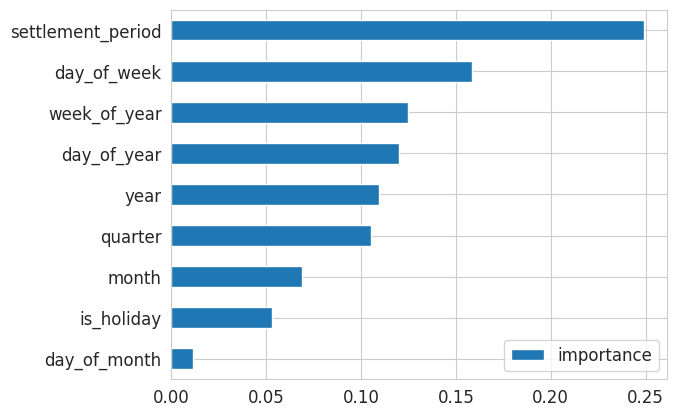

In [59]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh");

#### Forecast on test set

Once the model is trained, it can be used to predict the demand on the test set.

In [60]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

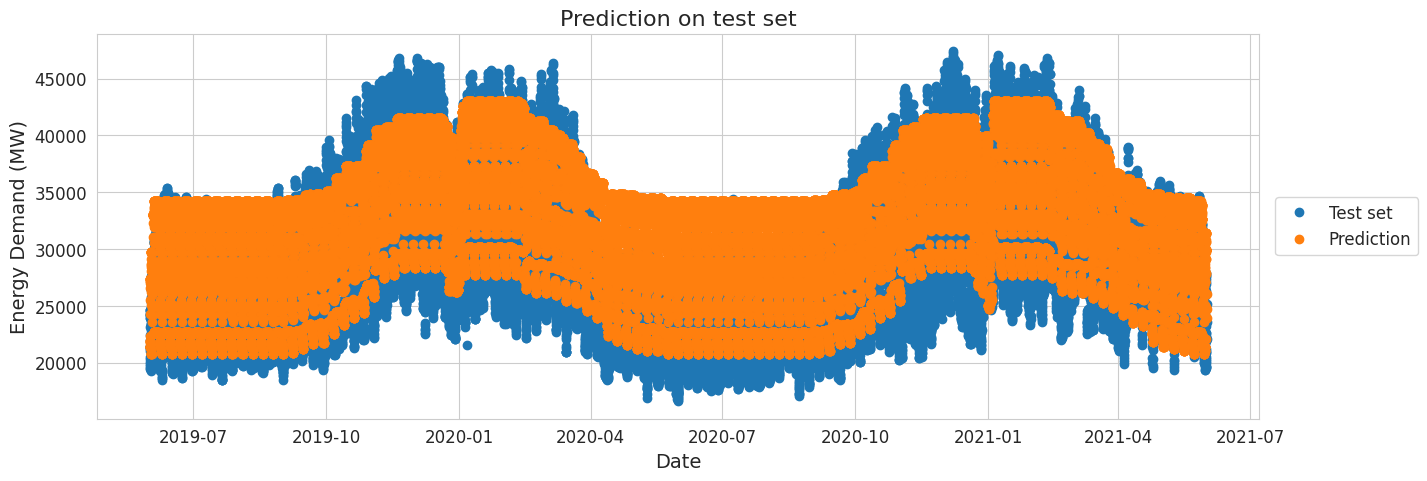

In [61]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Let's focus on a single week to see how the individual predictions perform compared to the test set:

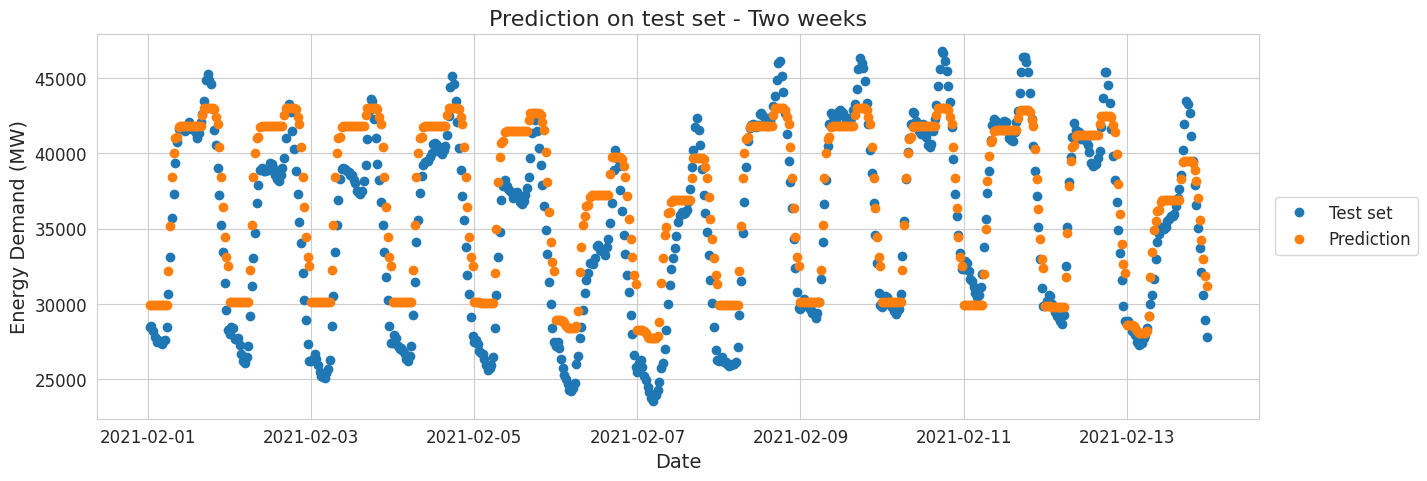

In [62]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

As can be seen, the model struggles to capture the peaks and valleys. This is a similar behaviour as [@carlmcbrideellis](https://www.kaggle.com/carlmcbrideellis) in [his kernel](https://www.kaggle.com/code/carlmcbrideellis/multivariate-time-series-forecasting-linear-tree) about linear trees. Tree based estimators don't generalise well for time series forecasting. In the next section I will use grid search to see if tuning the model hyperparameters leads to a better prediction.

In [63]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 11.29
Root Mean Squared Error of the simple models is: 3786.88 MW


## XGBoost with Cross validation and Grid Search

The model above is a good starting point, but it's still underfitted to the data. One can run the model again and change the hyperparameters,but it isn't the right way to train a model if we want to avoid overfitting. This problem can be solved by using cross validation and grid search.

### Cross Validation for time series

The first step is to create the data split for cross validation. Luckily, sklearn includes the class `TimeSeriesSplit` that will get the job done. Let's split the data and see what it looks like:

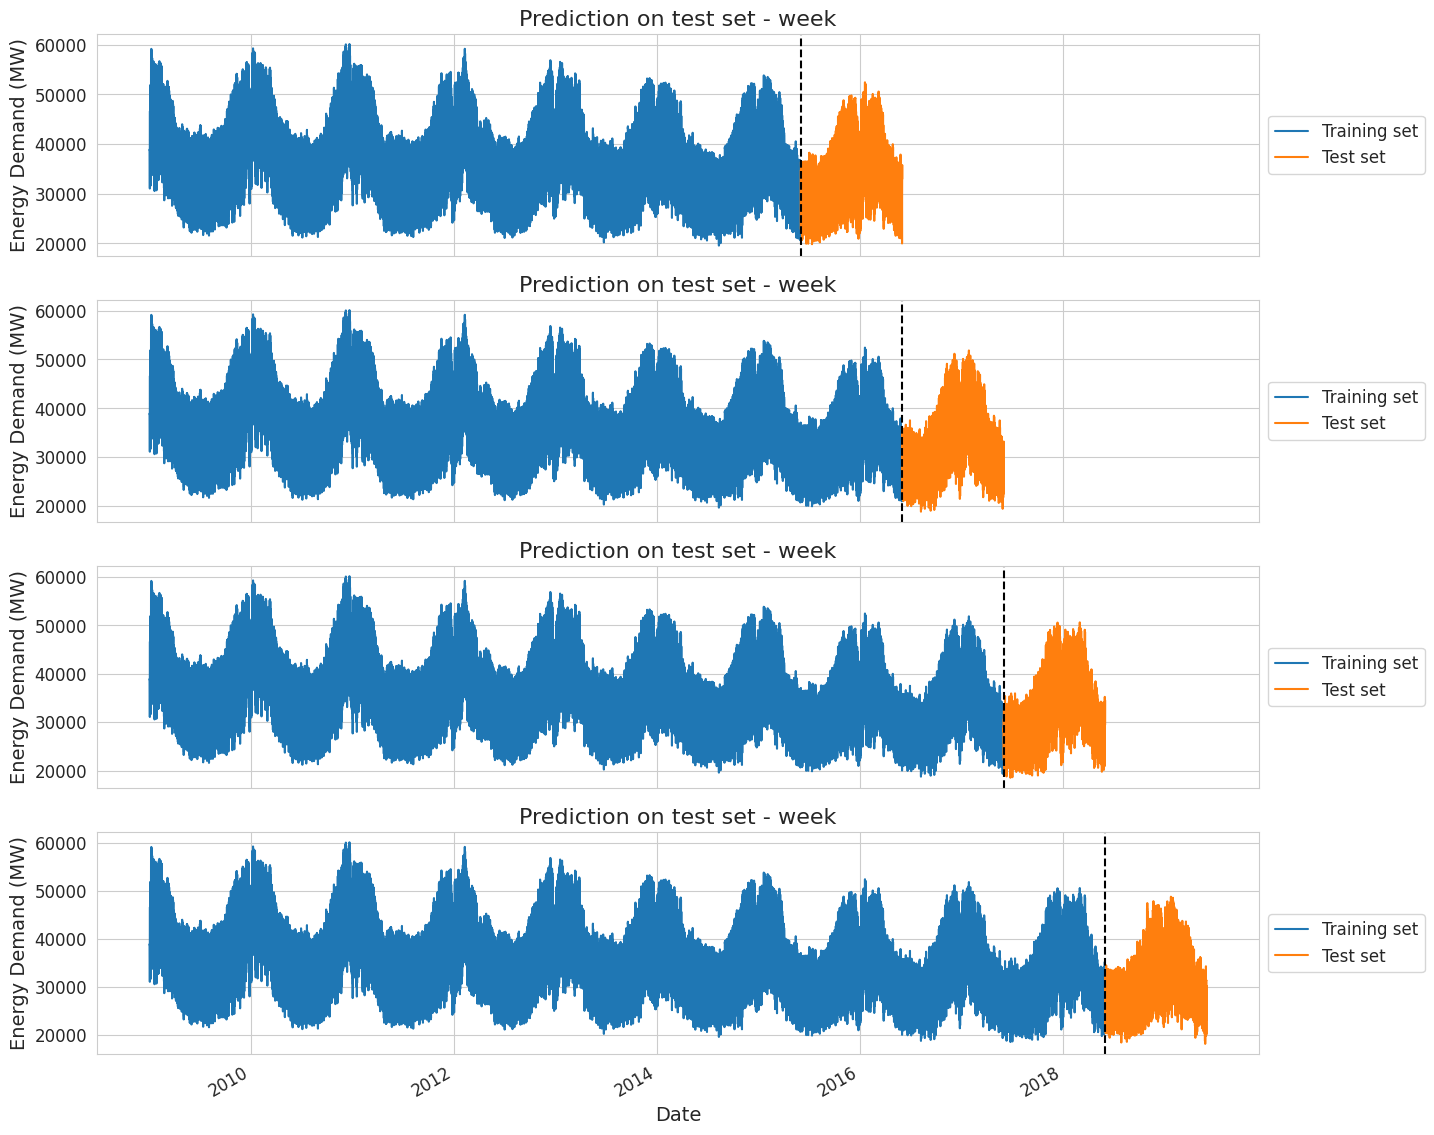

In [64]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

One can combine the cross validation technique for time series, called `TimeSeriesSplit` with GridSearchCV to find the best parameters for the XGBoost model.

For some reason, I kept getting a warning about the index of my timeseries being `pd.Int64Index`. Apparently, people are getting this error by simply using the xgboost package, as this [question on StackOverflow](https://stackoverflow.com/questions/71083866/pandas-int64index-fix-for-futurewarning) covers. I tried some of the suggested solutions, but it didn't work.

While I'm not a fan of hiding errors, this one isn't likely to affect the project in the future. Therefore, I will simply ignore this error using the solution shared in this [StackOverflow entry](https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings).

In [65]:
import warnings

def fxn():
    warnings.warn("FutureWarning", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

It's worth noting that the previous model uses a simple XGBoost regressor object with the early stopping option set to 50 iterations, but I didn't know how to combine this function with `GridSearchCV`. Luckily, this topic is covered in this entry [in StackOverflow](https://stackoverflow.com/questions/42993550/gridsearchcv-xgboost-early-stopping).

In [69]:
%%time

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]


# Define fit parameters to allow early stopping in GridSearchCV
# These will be passed to the estimator's fit method by GridSearchCV
fit_params = {
    "early_stopping_rounds": 50,
    "eval_metric": "rmse",
    "eval_set": [[X_hold_out, y_hold_out]],
}

# Define estimator
estimator = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    learning_rate=0.01,
    tree_method="gpu_hist",
    random_state=43,
)

# Define parameters to optimiser
param_search = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
}


# Create GridSearchCV object
# Pass fit_params to the GridSearchCV constructor's fit_params argument
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
     # Pass the fit_params here
)

# Call fit without unpacking fit_params again
xgb_search.fit(X_train_cv, y_train_cv, verbose=500);

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2043.594 total time=   0.9s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2565.997 total time=   0.6s
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2782.546 total time=   0.6s
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2330.722 total time=   0.6s
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2042.832 total time=   0.5s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2571.186 total time=   0.6s
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2785.871 total time=   0.6s
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2332.041 total time=   0.9s
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.7;, score=-2042.261 total time=   0.8s
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.7;, score=-2573.936 tota

GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=None, n_splits=4, test_size=17520),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=Non...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=43, ...),
             param_grid={'max_depth': [3, 5], 'n_estimators': [350, 500, 650],
                         'subsample': [0.95, 0.8, 0.7]},
             scoring='neg_root_mean_squared_error', verbose=3)

As one can see, it takes a long time to run each fold of the cross-validation. This can be sped up using the GPUs available on Kaggle, but that leads to an increase in runtime in the tasks carried out by CPUs as the number of CPUs is halved.

In [70]:
xgb_search.best_params_

{'max_depth': 5, 'n_estimators': 500, 'subsample': 0.95}

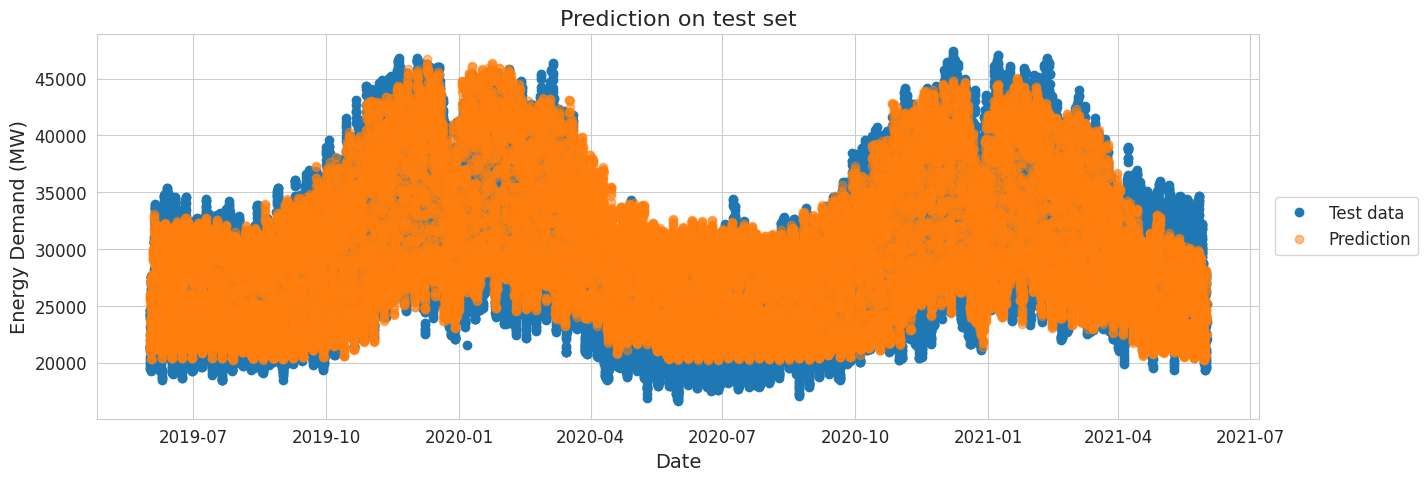

In [71]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

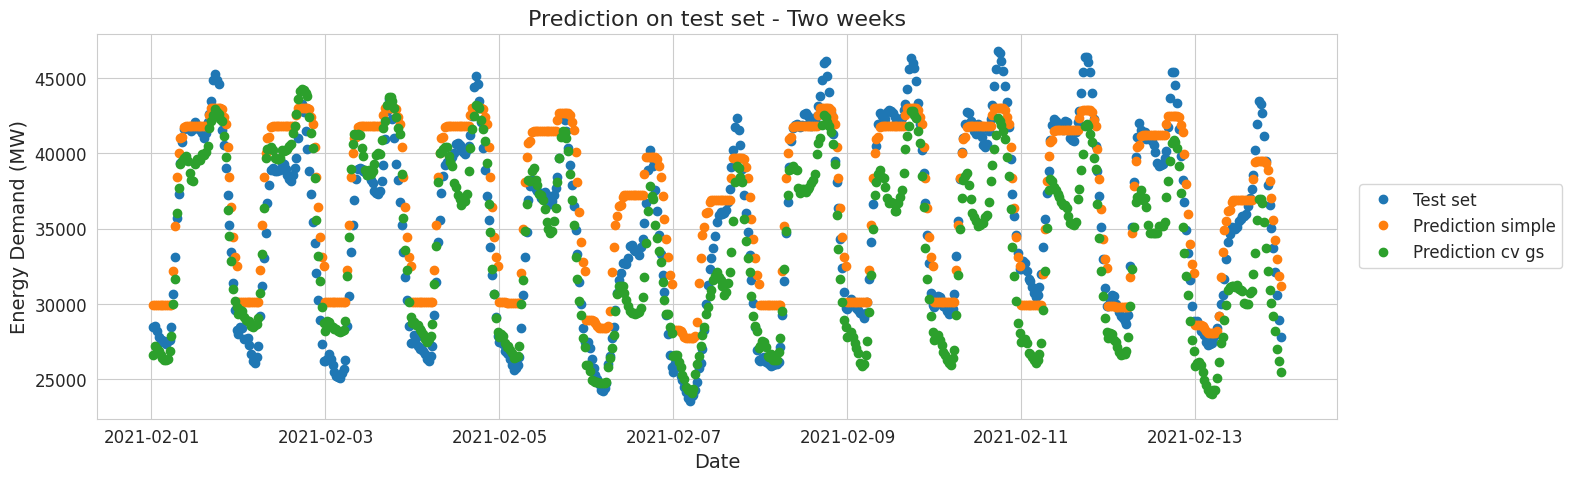

In [72]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

After tuning some hyperparameters, XGBoost does a better job in capturing the daily seasonality, but it struggles to accurately predict the peaks and valleys.

In [73]:
mape_xgboost_cv = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_cv_gs"]
)

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

Mean Absolute Percentage Error of the cross-validated model is: 7.30
Root Mean Squared Error of the cross-validated model is: 2659.11 MW


### Prediction into the future

Now that the best parameters have been found, the model can be fit using the entire dataset to then predict into the future.

In [83]:
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

# ... (previous code)

X_all = df[FEATURES_CV]
y_all = df[TARGET]

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    rounds=50,
)

# Pass the callback using callbacks instead of eval_callback
# Note: In newer XGBoost versions, consider passing early_stopping_rounds to the constructor instead.
xgb_best.fit(
    X_all,
    y_all,
   # eval_set=[(X_all, y_all)],
    verbose=100,
   # callbacks=[early_stopping_callback] # Changed eval_callback to callbacks
);

The next step is to build a dataframe that goes into the future:

In [84]:
def settlement_period(df):
    """
    Determine settlement period using dataframe index date. Each settlement period
    equates to 30-minute interval.
    Settlement period equal to 0 corresponds with 00:00:00 and settlement period 48
    corresponds with 23:30:00

    Args:
        - df: time series dataframe containing dates in the future

    Returns:
        - df: time series dataframe with settlement period column
    """

    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2 + np.array(df.index.minute.to_list()) / 30 + 1
    ).astype(int)


    df["settlement_period"] = settlement_period_array

    return df

In [85]:
prediction_days = 210

future = pd.date_range(
    str(df.index.max())[0:10],
    df.index.max() + datetime.timedelta(days=prediction_days),
    freq="30min",
)

future_df = pd.DataFrame(index=future)
future_df = settlement_period(future_df)
future_df["is_future"] = True
df["is_future"] = False

# Create a dataframe containing the original data and the predict df
df_and_future = pd.concat([df, future_df])

# add features and lag
# lag values will change w.r.t original dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# add bank holidays in future dataframe
df_and_future_wprediction = df_and_future.query("is_future").copy()

df_and_future_wprediction["settlement_date"] = df_and_future_wprediction.index.date
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)

df_and_future_wprediction.tail()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3,is_future,settlement_date
2025-07-03 21:30:00,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,184,3,7,2025,27,26993.0,26412.0,29516.0,True,2025-07-03
2025-07-03 22:00:00,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,184,3,7,2025,27,26036.0,25877.0,29170.0,True,2025-07-03
2025-07-03 22:30:00,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,184,3,7,2025,27,25201.0,24666.0,28013.0,True,2025-07-03
2025-07-03 23:00:00,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,184,3,7,2025,27,23691.0,23066.0,27610.0,True,2025-07-03
2025-07-03 23:30:00,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,184,3,7,2025,27,23143.0,21865.0,26711.0,True,2025-07-03


As can be seen, the last rows of the new dataframe go into the future.

Now, the XGBoost model can be used to predict into the future:

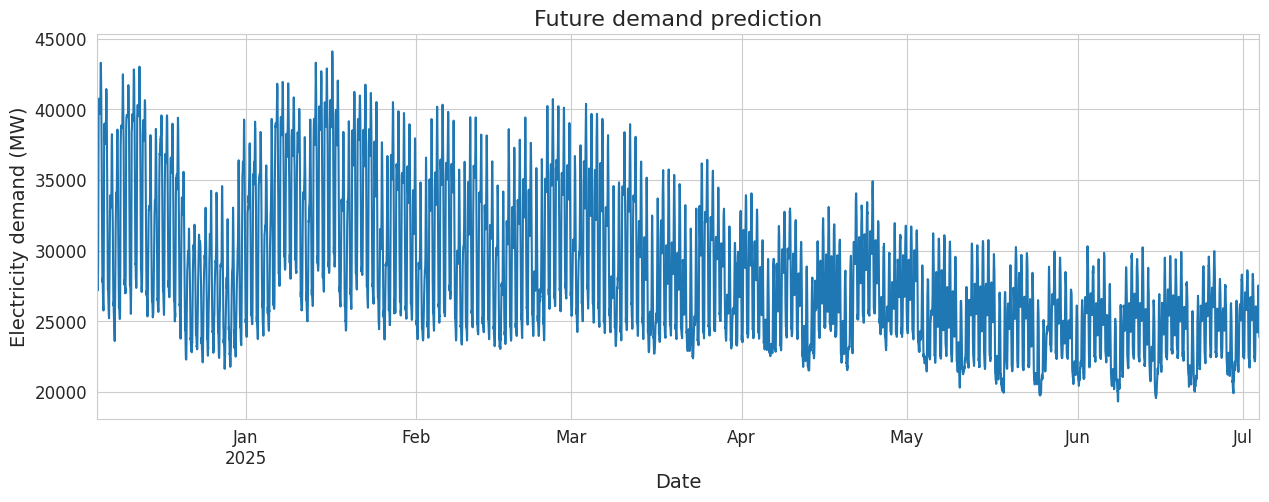

In [86]:
df_and_future_wprediction["pred_xgboost"] = xgb_best.predict(
    df_and_future_wprediction[FEATURES_CV]
)


fig, ax = plt.subplots(figsize=(15, 5))
df_and_future_wprediction["pred_xgboost"].plot(figsize=(15, 5), style="-", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

## Deep LSTM

In [131]:
# Create and compile neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = root_mean_squared_error
mode="min"
early_stopping = EarlyStopping(monitor=root_mean_squared_error, patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    "./models_data/deep_lstm/checkpoint.weights.h5", # Changed filepath to end with .weights.h5
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history_deep_lstm = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=50,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)

Epoch 1/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.1706 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 2/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0981 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 3/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0880 - val_loss: 0.0367 - learning_rate: 0.0010
Epoch 4/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0805 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 5/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0745 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 6/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0723 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 7/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0710 - val_loss: 0.0342 - learning_rate: 0.0010
Epoch 8/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0701 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 9/50
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0690 - val_loss: 0.0325 - learni

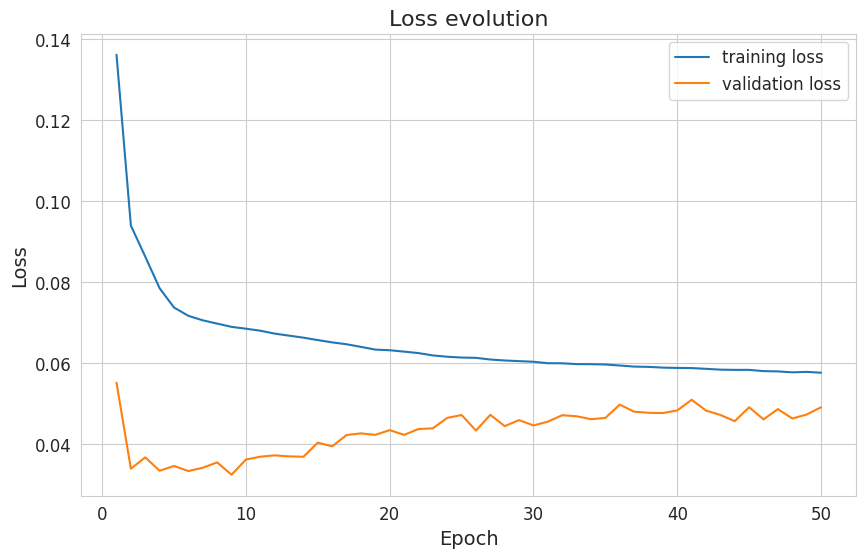

In [132]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

Similarly to the previous LSTM model, the output needs to inverse transformed.

In [133]:
# Prediction on test set
pred_deep_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = pred_deep_lstm.reshape(pred_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_deep_lstm"] = results_deep_lstm[:,-1]

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


Let's check the predictions:

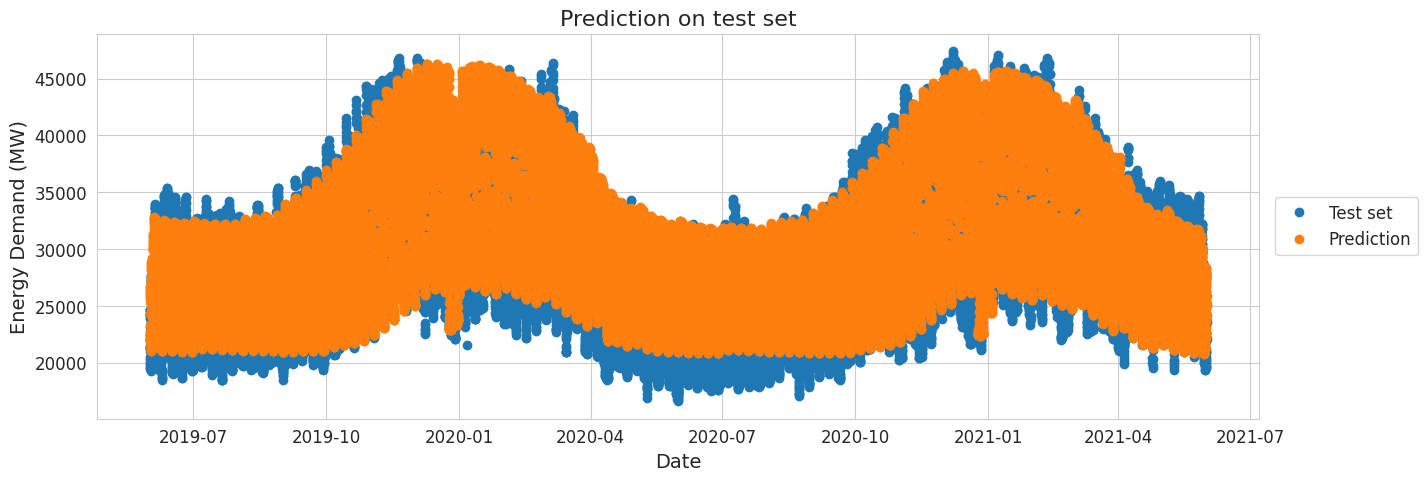

In [134]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_deep_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

It seems like the model is much better at predicting the maximum daily values and it has improved its performance over the winter period, but somehow the summer predictions look worse... Again, the maximum values are better predicted, but the minimum values, especially for 2020 are way off.

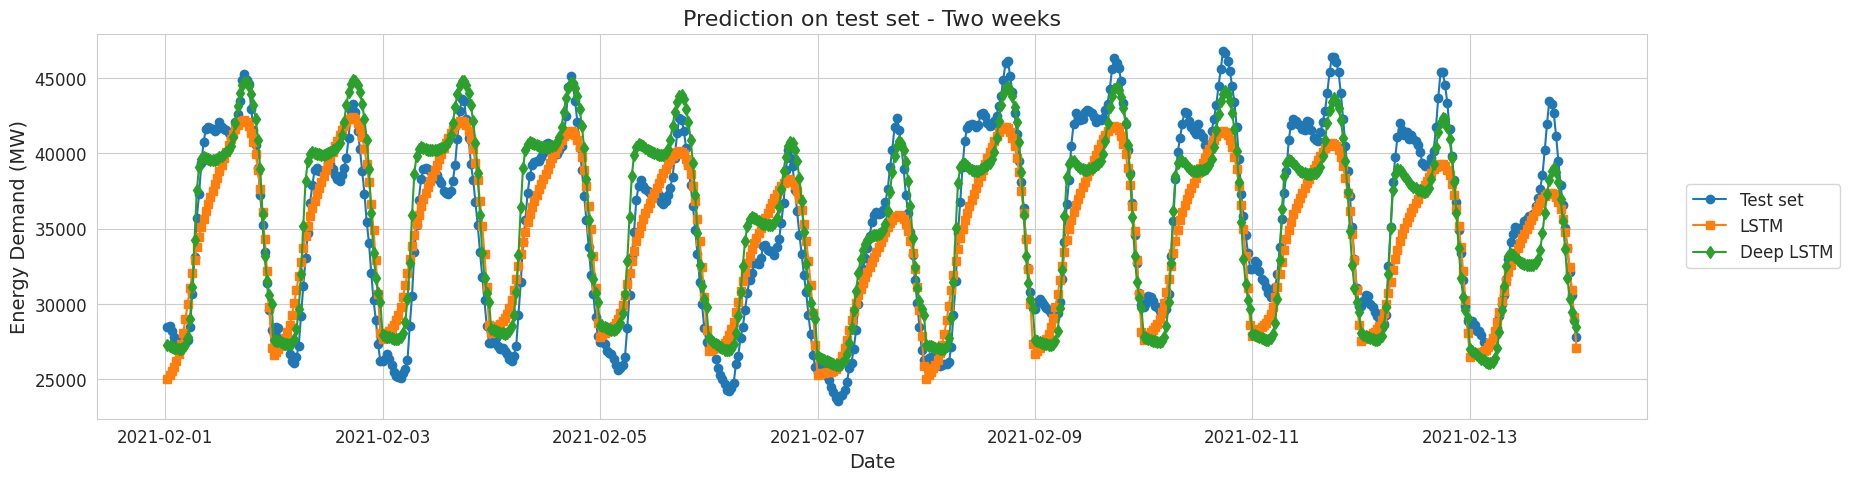

In [135]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_deep_lstm"
    ],
    "-d",
    label="Deep LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

The above two-week period shows that the deep LSTM network performs better than the simple LSTM network. It seems like the shape of the daily pattern is almost perfect, although the amplitude isn't correct.

However, this two-week period belongs to the winter season, which as seen above, it seems much better for the deep LSTM model. MAPE and RMSE values will help understand if the overall performance of the deep LSTM network is actually better.

In [136]:
mape_deep_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_deep_lstm"]
)

rmse_deep_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_deep_lstm"]))

print(
    "Mean Absolute Percentage Error of the deep LSTM model is: %.2f" % mape_deep_lstm
)

print(
    "Root Mean Squared Error of the deep LSTM model is: %.2f MW" % rmse_deep_lstm
)

Mean Absolute Percentage Error of the deep LSTM model is: 7.76
Root Mean Squared Error of the deep LSTM model is: 2714.46 MW


**XGBoost** has proven why in the recent years it has become the go-to algorithm for many problems. A simple XGBoost model and a single train-test split results in a MAPE value of 9.2%. Surely the model needs more work and tuning, but a couple of lines of code gave me a very accurate prediction I couldn't get that accuracy level with SARIMA after spending hours tweaking the parameters.

While a single train-test split isn't the optimal way to train a model, the combination of cross-validation and grid search with a hold-out set for independent evaluation is the right way to do things. This option yields an error of 7.3%, which is a great value since I only tuned a few hyperparameters.


**LSTM** recurrent networks show a great performance and the ability to use GPUs to speed up the training makes them a very atractive option. I'm glad I didn't jump stratight into this approach, which has become the go-to approach for time-series forecasting, but it has proven why it's such a great choice.

